In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import fastparquet

In [3]:
def read_train():
    train_test =  fastparquet.ParquetFile("../input/train_test.parq").to_pandas()
    return train_test[train_test['istrain']]

In [4]:
%time train=read_train()
train.shape

CPU times: user 28.9 s, sys: 18.9 s, total: 47.8 s
Wall time: 47.7 s


(125497040, 15)

In [5]:
train.head()

date  istrain  item_nbr  onpromotion  store_nbr  unit_sales  \
index                                                                     
0     2013-01-01     True    103665           -1         25    2.079442   
1     2013-01-01     True    105574           -1         25    0.693147   
2     2013-01-01     True    105575           -1         25    1.098612   
3     2013-01-01     True    108079           -1         25    0.693147   
4     2013-01-01     True    108701           -1         25    0.693147   

       dcoilwtico  city  state  type  cluster  holiday  family  class  \
index                                                                   
0             NaN    20     13     3        1     True       5   2712   
1             NaN    20     13     3        1     True      12   1045   
2             NaN    20     13     3        1     True      12   1045   
3             NaN    20     13     3        1     True      12   1030   
4             NaN    20     13     3        1     True       9   2644   

       perishable  
index              
0               1  
1               0  
2               0  
3               0  
4               1

In [6]:
mean_target=train[['date','unit_sales']].groupby('date').mean()['unit_sales']

In [7]:
oil=train[['date','holiday']].groupby('date').mean()['holiday']

In [8]:
from rpy2.robjects.packages import importr

In [9]:
%load_ext rpy2.ipython

In [10]:
%R .libPaths(c("/home/spark/R/x86_64-redhat-linux-gnu-library/3.4","/usr/lib64/R/library"))

array(['/home/spark/R/x86_64-redhat-linux-gnu-library/3.4',
       '/usr/lib64/R/library', '/home/spark/anaconda2/lib/R/library'],
      dtype='|S49')

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
%R  require(xts) 

array([1], dtype=int32)

In [13]:
%%R -i oil
oil <- zoo(oil,as.Date(names(oil)))
head(oil)

2013-01-01 2013-01-02 2013-01-03 2013-01-04 2013-01-05 2013-01-06 
         1          0          0          0          1          0 


In [14]:
%%R -i mean_target
mean_target <- zoo(mean_target,as.Date(names(mean_target)))
head(mean_target)

2013-01-01 2013-01-02 2013-01-03 2013-01-04 2013-01-05 2013-01-06 
  1.350484   2.026989   1.847432   1.818331   1.982967   2.029279 


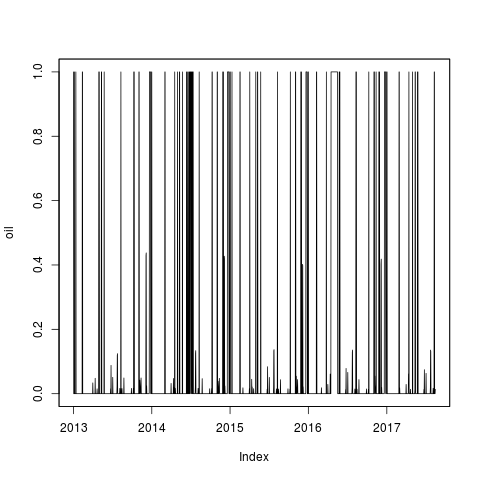

In [15]:
%%R
plot(oil,screens=c(1,2))
plot(mean_target,screens=1)

In [16]:
%%R
joined <- na.locf(na.locf(merge(mean_target,oil)),fromLast=TRUE)

In [17]:
%R str(joined)

‘zoo’ series from 2013-01-01 to 2017-08-15
  Data: num [1:1684, 1:2] 1.35 2.03 1.85 1.82 1.98 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "mean_target" "oil"
  Index:  Date[1:1684], format: "2013-01-01" "2013-01-02" "2013-01-03" "2013-01-04" "2013-01-05" ...


[1] 0


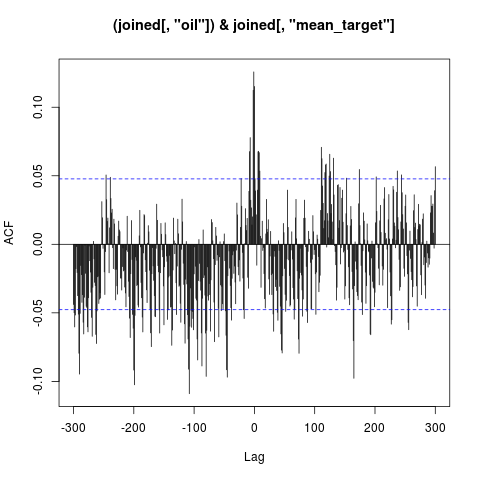

In [23]:
%%R   -o ret
ret <- ccf( (joined[,'oil']),joined[,'mean_target'], na.action = na.pass,lag.max=300);
ccf( apply.weekly(joined[,'oil'],mean),apply.weekly(joined[,'mean_target'],mean), na.action = na.pass);
ccf( apply.monthly(joined[,'oil'],mean),apply.monthly(joined[,'mean_target'],mean), na.action = na.pass);

-300+which.max(ret$acf)

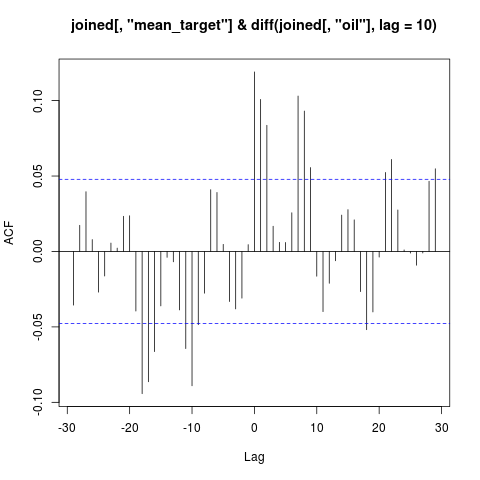

In [22]:
%%R   
ccf(joined[,'mean_target'],diff(joined[,'oil'],lag=10), na.action = na.pass);
ccf(joined[,'mean_target'],diff(joined[,'oil'],lag=200), na.action = na.pass);

In [25]:
%R help(ccf)

array(['/home/spark/anaconda2/lib/R/library/stats/help/acf'],
      dtype='|S50')

In [26]:
import gc
gc.collect()

713